## Modules and data preparation

In [1]:
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import Binarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import *
from sklearn.tree import *

In [2]:
from pandas import DataFrame

def data_normalization(df: DataFrame, days_range: int=20, include_cur_row: bool=False):
    '''
    Return the normalized data:
    + df: the dataframe to be normalized
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
    df_roll = None

    if include_cur_row == False:
        df_roll = df.rolling(days_range, closed='left')
    else:
        df_roll = df.rolling(days_range)
        
    res_df = (df - df_roll.mean()) / df_roll.std()
    res_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return res_df[20:]


def data_denormalization(predictions, original_df: DataFrame, days_range: int=20, include_cur_row: bool=False):
    '''
    Return the original data:
    + df: the dataframe to be denormalized
    + original_df: the dataframe used for normalizing df befoe
    + range: the number of previous rows (or including the current row) to be considered in the normalization
    + include_cur_row: True if we consider the current row in the normalization process (calculate mean and std
    using the current row and (range-1) previous rows), False if we want to use all the passed data for normalization 
    processing ((calculate mean and std using (range) previous rows))
    '''
    
#     df_roll = None
#     if include_cur_row == False:
#         df_roll = original_df.rolling(days_range, closed='left')
#     else:
#         df_roll = original_df.rolling(days_range)
    
    res_df = predictions * original_df["close_std20"] + original_df["close_price_SMA20"]

    return res_df

In [3]:
df = pd.read_csv("../../data/data_1h_with_features_ver02.csv")

In [4]:
df

,Time_UTC_Start,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,...,low_RSI72,low_std72,low_median72,open_price_EMA72,open_price_SMA72,open_price_WMA72,open_RS72,open_RSI72,open_std72,open_median72
0,2018-07-24 09:00:00,7991.55,7995.89,7991.52,7994.86,31.547768,2.521824e+05,114.0,17.411796,139194.088209,...,66.388050,181.841510,7511.865,7629.074361,7569.749167,7665.486347,2.004297,66.714344,181.638845,7512.345
1,2018-07-24 10:00:00,8022.05,8032.85,8022.05,8032.85,11.358339,9.117570e+04,136.0,7.730805,62059.658337,...,66.682239,187.166134,7516.550,7639.840817,7579.412222,7677.878151,2.034496,67.045599,186.862348,7517.035
2,2018-07-24 11:00:00,8140.18,8145.00,8135.00,8135.00,61.441457,5.001102e+05,296.0,29.340389,238843.014408,...,69.079552,195.397878,7522.015,7653.548740,7591.068056,7693.241651,2.296713,69.666760,195.121249,7524.000
3,2018-07-24 12:00:00,8257.98,8266.61,8255.02,8263.01,36.020530,2.976317e+05,317.0,16.279052,134510.633427,...,70.577953,207.641424,7524.530,7670.108500,7604.176389,7711.513212,2.458304,71.084095,207.395845,7528.015
4,2018-07-24 13:00:00,8218.71,8228.68,8216.45,8220.00,59.458543,4.887918e+05,284.0,31.777879,261222.842840,...,69.036456,217.410106,7530.060,7685.138678,7616.422361,7728.349749,2.284430,69.553319,217.064045,7533.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33186,2022-05-07 03:00:00,35953.63,35953.64,35943.60,35951.24,6.376430,2.292318e+05,339.0,3.818980,137290.253366,...,41.661523,1545.491038,37507.605,37188.015100,37717.645417,36999.914669,0.698633,41.129120,1542.780667,37517.625
33187,2022-05-07 04:00:00,35812.22,35826.14,35812.21,35826.14,6.066650,2.173069e+05,348.0,5.129450,183735.644012,...,40.964133,1560.566848,36925.375,37150.322083,37687.070417,36947.711233,0.676629,40.356512,1558.347303,36973.110
33188,2022-05-07 05:00:00,35746.62,35768.06,35722.24,35768.05,34.156320,1.220607e+06,993.0,19.901990,711168.120653,...,40.727389,1576.446817,36807.580,37111.864492,37655.791528,36894.548208,0.671629,40.178113,1574.298464,36863.110
33189,2022-05-07 06:00:00,35898.96,35903.80,35890.03,35900.00,16.707700,5.997658e+05,580.0,10.902570,391364.049595,...,41.109026,1588.574398,36654.190,37078.634232,37625.340972,36846.415837,0.680325,40.487702,1586.732616,36684.760


In [5]:
df.drop(columns=["Time_UTC_Start"], inplace=True)

In [6]:
X = df.drop(columns=["close"])
X = X.iloc[:-1,:]
y = df["close"].shift(1)
y.dropna(inplace=True)

In [7]:
X

,open,high,low,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,label,TR,...,low_RSI72,low_std72,low_median72,open_price_EMA72,open_price_SMA72,open_price_WMA72,open_RS72,open_RSI72,open_std72,open_median72
0,7991.55,7995.89,7991.52,31.547768,2.521824e+05,114.0,17.411796,139194.088209,1.0,4.37,...,66.388050,181.841510,7511.865,7629.074361,7569.749167,7665.486347,2.004297,66.714344,181.638845,7512.345
1,8022.05,8032.85,8022.05,11.358339,9.117570e+04,136.0,7.730805,62059.658337,1.0,10.80,...,66.682239,187.166134,7516.550,7639.840817,7579.412222,7677.878151,2.034496,67.045599,186.862348,7517.035
2,8140.18,8145.00,8135.00,61.441457,5.001102e+05,296.0,29.340389,238843.014408,0.0,10.00,...,69.079552,195.397878,7522.015,7653.548740,7591.068056,7693.241651,2.296713,69.666760,195.121249,7524.000
3,8257.98,8266.61,8255.02,36.020530,2.976317e+05,317.0,16.279052,134510.633427,1.0,11.59,...,70.577953,207.641424,7524.530,7670.108500,7604.176389,7711.513212,2.458304,71.084095,207.395845,7528.015
4,8218.71,8228.68,8216.45,59.458543,4.887918e+05,284.0,31.777879,261222.842840,1.0,12.23,...,69.036456,217.410106,7530.060,7685.138678,7616.422361,7728.349749,2.284430,69.553319,217.064045,7533.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33185,36017.06,36023.41,36017.05,4.589230,1.653070e+05,288.0,2.971990,107051.000646,1.0,6.36,...,42.297108,1531.731413,37978.145,37222.786511,37745.548056,37049.008314,0.716642,41.746745,1528.727701,37980.660
33186,35953.63,35953.64,35943.60,6.376430,2.292318e+05,339.0,3.818980,137290.253366,0.0,10.04,...,41.661523,1545.491038,37507.605,37188.015100,37717.645417,36999.914669,0.698633,41.129120,1542.780667,37517.625
33187,35812.22,35826.14,35812.21,6.066650,2.173069e+05,348.0,5.129450,183735.644012,1.0,13.93,...,40.964133,1560.566848,36925.375,37150.322083,37687.070417,36947.711233,0.676629,40.356512,1558.347303,36973.110
33188,35746.62,35768.06,35722.24,34.156320,1.220607e+06,993.0,19.901990,711168.120653,1.0,45.82,...,40.727389,1576.446817,36807.580,37111.864492,37655.791528,36894.548208,0.671629,40.178113,1574.298464,36863.110


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle=False)

In [9]:
days_range=20

In [10]:
norm_X_train = data_normalization(X_train)
norm_y_train = data_normalization(y_train)

norm_X_val = data_normalization(X_val)
norm_y_val = data_normalization(y_val)

norm_X_test = data_normalization(X_test)
norm_y_test = data_normalization(y_test)

## 1. Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(norm_X_val, norm_y_val)

LinearRegression()

In [12]:
a = data_denormalization(lr.predict(norm_X_test), y_test)
a.dropna(inplace=True)
a

KeyError: 'close_std20'

In [ ]:
y_test = y_test.iloc[20:]
y_test = y_test.reset_index(drop=True)
a = a.reset_index(drop=True)
((a - y_test.shift(1))*(y_test - y_test.shift(1))>=0).sum()/y_test.shape[0]

## 2. LightGBM classification

In [15]:
import lightgbm as lgb

price_types = ["close", "high", "low", "open"]
days_ranges = [4,8,12,16,20,24,48,72]
features = ["std", "price_SMA", "price_EMA", "price_WMA", "median", "RS", "RSI"] #"volume_SMA", "volume_EMA", "volume_WMA",

df = pd.read_csv("../../data/data_1h_with_features_ver02.csv")
df.drop(columns=["Time_UTC_Start"], inplace=True)

# df = df[["open", "high", "close", "volume", "low", "label"]]

# "CCI20", "BOP4", "high_RS8", "CCI12", "CCI16", "CCI24", "low_RSI4", "open_RS12", "plus_DI12", "high_RSI16"

for i in range(len(days_ranges)-1):
    for j in range(i+1, len(days_ranges)):
        for price_type in price_types:
            for feature in features:
                df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
                
                
for days_range in days_ranges:
    for price_type1 in price_types:
        for price_type2 in price_types:
            for feature in features:
                df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
            

for feature in ["CCI", "BOP", "ADX"]:
    for i in range(len(days_ranges)-1): 
        for j in range(i+1, len(days_ranges)):
            df["diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[feature+str(days_ranges[i])]/df[feature+str(days_ranges[j])]

for i in range(1,9):
    a = df[["open", "high", "close", "volume", "low", "label", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]].shift(i)
    a.columns += str(i)
    df = pd.concat((df, a), axis=1)
    for price_type1 in price_types:
        for price_type2 in price_types:
            df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_price_" + str(i) + "_ago"] =  df[price_type1]/df[price_type2].shift(i)
    
df.dropna(inplace=True)

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ra

/tmp/ipykernel_11951/2912874162.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + price_type + "_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[price_type+"_"+feature+str(days_ranges[i])]/df[price_type+"_"+feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_cur_" + price_type1 + "_price-" + price_type2 + "_" + feature + str(days_range)] = df[price_type1]/df[price_type2+"_"+feature+str(days_range)]
/tmp/ipykernel_11951/2912874162.py:25: PerformanceWarning: D

/tmp/ipykernel_11951/2912874162.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[feature+str(days_ranges[i])]/df[feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[feature+str(days_ranges[i])]/df[feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:31: PerformanceWarning: DataFrame is highly fragmente

/tmp/ipykernel_11951/2912874162.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[feature+str(days_ranges[i])]/df[feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_" + feature + str(days_ranges[i]) + "-" + str(days_ranges[j])] = df[feature+str(days_ranges[i])]/df[feature+str(days_ranges[j])]
/tmp/ipykernel_11951/2912874162.py:31: PerformanceWarning: DataFrame is highly fragmente

In [16]:
df.ffill(inplace=True)
df.isna().any().sum()

0

In [17]:
df.reset_index(inplace=True, drop=True)
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,label,...,diff_cur_high_price-low_price_8_ago,diff_cur_high_price-open_price_8_ago,diff_cur_low_price-close_price_8_ago,diff_cur_low_price-high_price_8_ago,diff_cur_low_price-low_price_8_ago,diff_cur_low_price-open_price_8_ago,diff_cur_open_price-close_price_8_ago,diff_cur_open_price-high_price_8_ago,diff_cur_open_price-low_price_8_ago,diff_cur_open_price-open_price_8_ago
0,8186.98,8190.00,8183.30,8184.56,8.920808,7.303759e+04,150.0,3.447118,28224.481465,0.0,...,1.024836,1.024832,1.023570,1.023438,1.023998,1.023994,1.024030,1.023899,1.024458,1.024455
1,8244.80,8245.00,8238.89,8240.22,11.643656,9.597343e+04,124.0,3.671446,30263.603451,0.0,...,1.027792,1.027792,1.025650,1.025650,1.027030,1.027030,1.026385,1.026385,1.027767,1.027767
2,8258.34,8270.76,8253.96,8266.51,17.397485,1.437507e+05,132.0,12.888519,106489.776429,1.0,...,1.016688,1.016041,1.014623,1.013378,1.014623,1.013978,1.015162,1.013915,1.015162,1.014516
3,8266.24,8267.98,8265.00,8266.15,20.780132,1.717746e+05,145.0,10.638645,87945.209399,0.0,...,1.001570,1.001211,1.000241,0.999805,1.001209,1.000850,1.000391,0.999955,1.001359,1.001000
4,8235.06,8241.78,8235.06,8240.01,27.349427,2.253137e+05,126.0,13.953942,114953.784130,1.0,...,1.003083,1.002807,1.001832,1.000775,1.002265,1.001989,1.001832,1.000775,1.002265,1.001989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33110,35953.63,35953.64,35943.60,35951.24,6.376430,2.292318e+05,339.0,3.818980,137290.253366,0.0,...,1.001303,1.000380,1.000815,0.999693,1.001024,1.000100,1.001094,0.999972,1.001303,1.000379
33111,35812.22,35826.14,35812.21,35826.14,6.066650,2.173069e+05,348.0,5.129450,183735.644012,1.0,...,0.996832,0.995134,0.996444,0.994598,0.996444,0.994747,0.996444,0.994599,0.996445,0.994747
33112,35746.62,35768.06,35722.24,35768.05,34.156320,1.220607e+06,993.0,19.901990,711168.120653,1.0,...,0.991285,0.991285,0.989536,0.989536,0.990015,0.990015,0.990211,0.990211,0.990691,0.990691
33113,35898.96,35903.80,35890.03,35900.00,16.707700,5.997658e+05,580.0,10.902570,391364.049595,1.0,...,0.998642,0.998452,0.998154,0.998069,0.998259,0.998069,0.998403,0.998317,0.998508,0.998317


In [18]:
saved_df = df.copy()

In [19]:
if True:
    diff_columns = []

    for col in df.columns:
        if "diff" in col or "label" in col:
            diff_columns.append(col)

    df = df[diff_columns]

In [31]:
X = df.drop(columns=["label"])
X = X.iloc[:-1,:]
y = df["label"].shift(-1)
y.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=False)

# norm_X_train = X_train
# norm_y_train = y_train

# norm_X_val = X_val
# norm_y_val = y_val

# norm_X_test = X_test
# norm_y_test = y_test

norm_X_train = data_normalization(X_train)
norm_y_train = data_normalization(y_train)

norm_X_val = data_normalization(X_val)
norm_y_val = data_normalization(y_val)

norm_X_test = data_normalization(X_test)
norm_y_test = data_normalization(y_test)

In [40]:
depth = 3
rate = 0.6
lr = 0.1

print("rate =", rate)
train_data = lgb.Dataset(norm_X_train, norm_y_train)
valid_data = lgb.Dataset(norm_X_val, norm_y_val)

params = {'objective': 'binary',
                      'metric': ['auc'],
                      'boosting':'gbdt',
                      'num_boost_round':500,
                      'early_stopping_rounds':10,
                      'learning_rate': lr,
                      'max_depth': depth,
                      'num_leaves': 2**depth,
                      'feature_fraction': rate,
#                       'bagging_fraction': 0.8,
#                       'min_data_in_leaf': 10,
                      'verbosity': 1}

model = lgb.train(params, train_data,                     
                  valid_sets=[train_data, valid_data],
                  valid_names=['train', 'valid'])

rate = 0.6


/home/hoangvictor/Installations/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8045, number of negative: 7829
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 485352
[LightGBM] [Info] Number of data points in the train set: 15874, number of used features: 1904
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506804 -> initscore=0.027216
[LightGBM] [Info] Start training from score 0.027216
[1]	train's auc: 0.622209	valid's auc: 0.683189
Training until validation scores don't improve for 10 rounds
[2]	train's auc: 0.627569	valid's auc: 0.69019
[3]	train's auc: 0.631657	valid's auc: 0.693256
[4]	train's auc: 0.633244	valid's auc: 0.695475
[5]	train's auc: 0.635211	valid's auc: 0.697531
[6]	train's auc: 0.637342	valid's auc: 0.696553
[7]	train's auc: 0.639296	valid's auc: 0.698536
[8]	train's auc: 0.641038	valid's auc: 0.698621
[9]	train's auc: 0.642058	valid's auc: 0.69898
[10]	train's

In [41]:
predicted_y = model.predict(norm_X_test).reshape(-1, 1)
target_y = y_test.to_numpy()[20:]

print(classification_report(target_y, Binarizer(threshold=0.5).fit_transform(predicted_y)))
print(confusion_matrix(target_y, Binarizer(threshold=0.5).fit_transform(predicted_y)))

acc = accuracy_score(target_y, Binarizer(threshold=0.5).fit_transform(predicted_y))
print("Accuracy:", acc)

              precision    recall  f1-score   support

         0.0       0.57      0.55      0.56      6270
         1.0       0.61      0.62      0.61      6956

    accuracy                           0.59     13226
   macro avg       0.59      0.59      0.59     13226
weighted avg       0.59      0.59      0.59     13226

[[3451 2819]
 [2621 4335]]
Accuracy: 0.5886889460154242


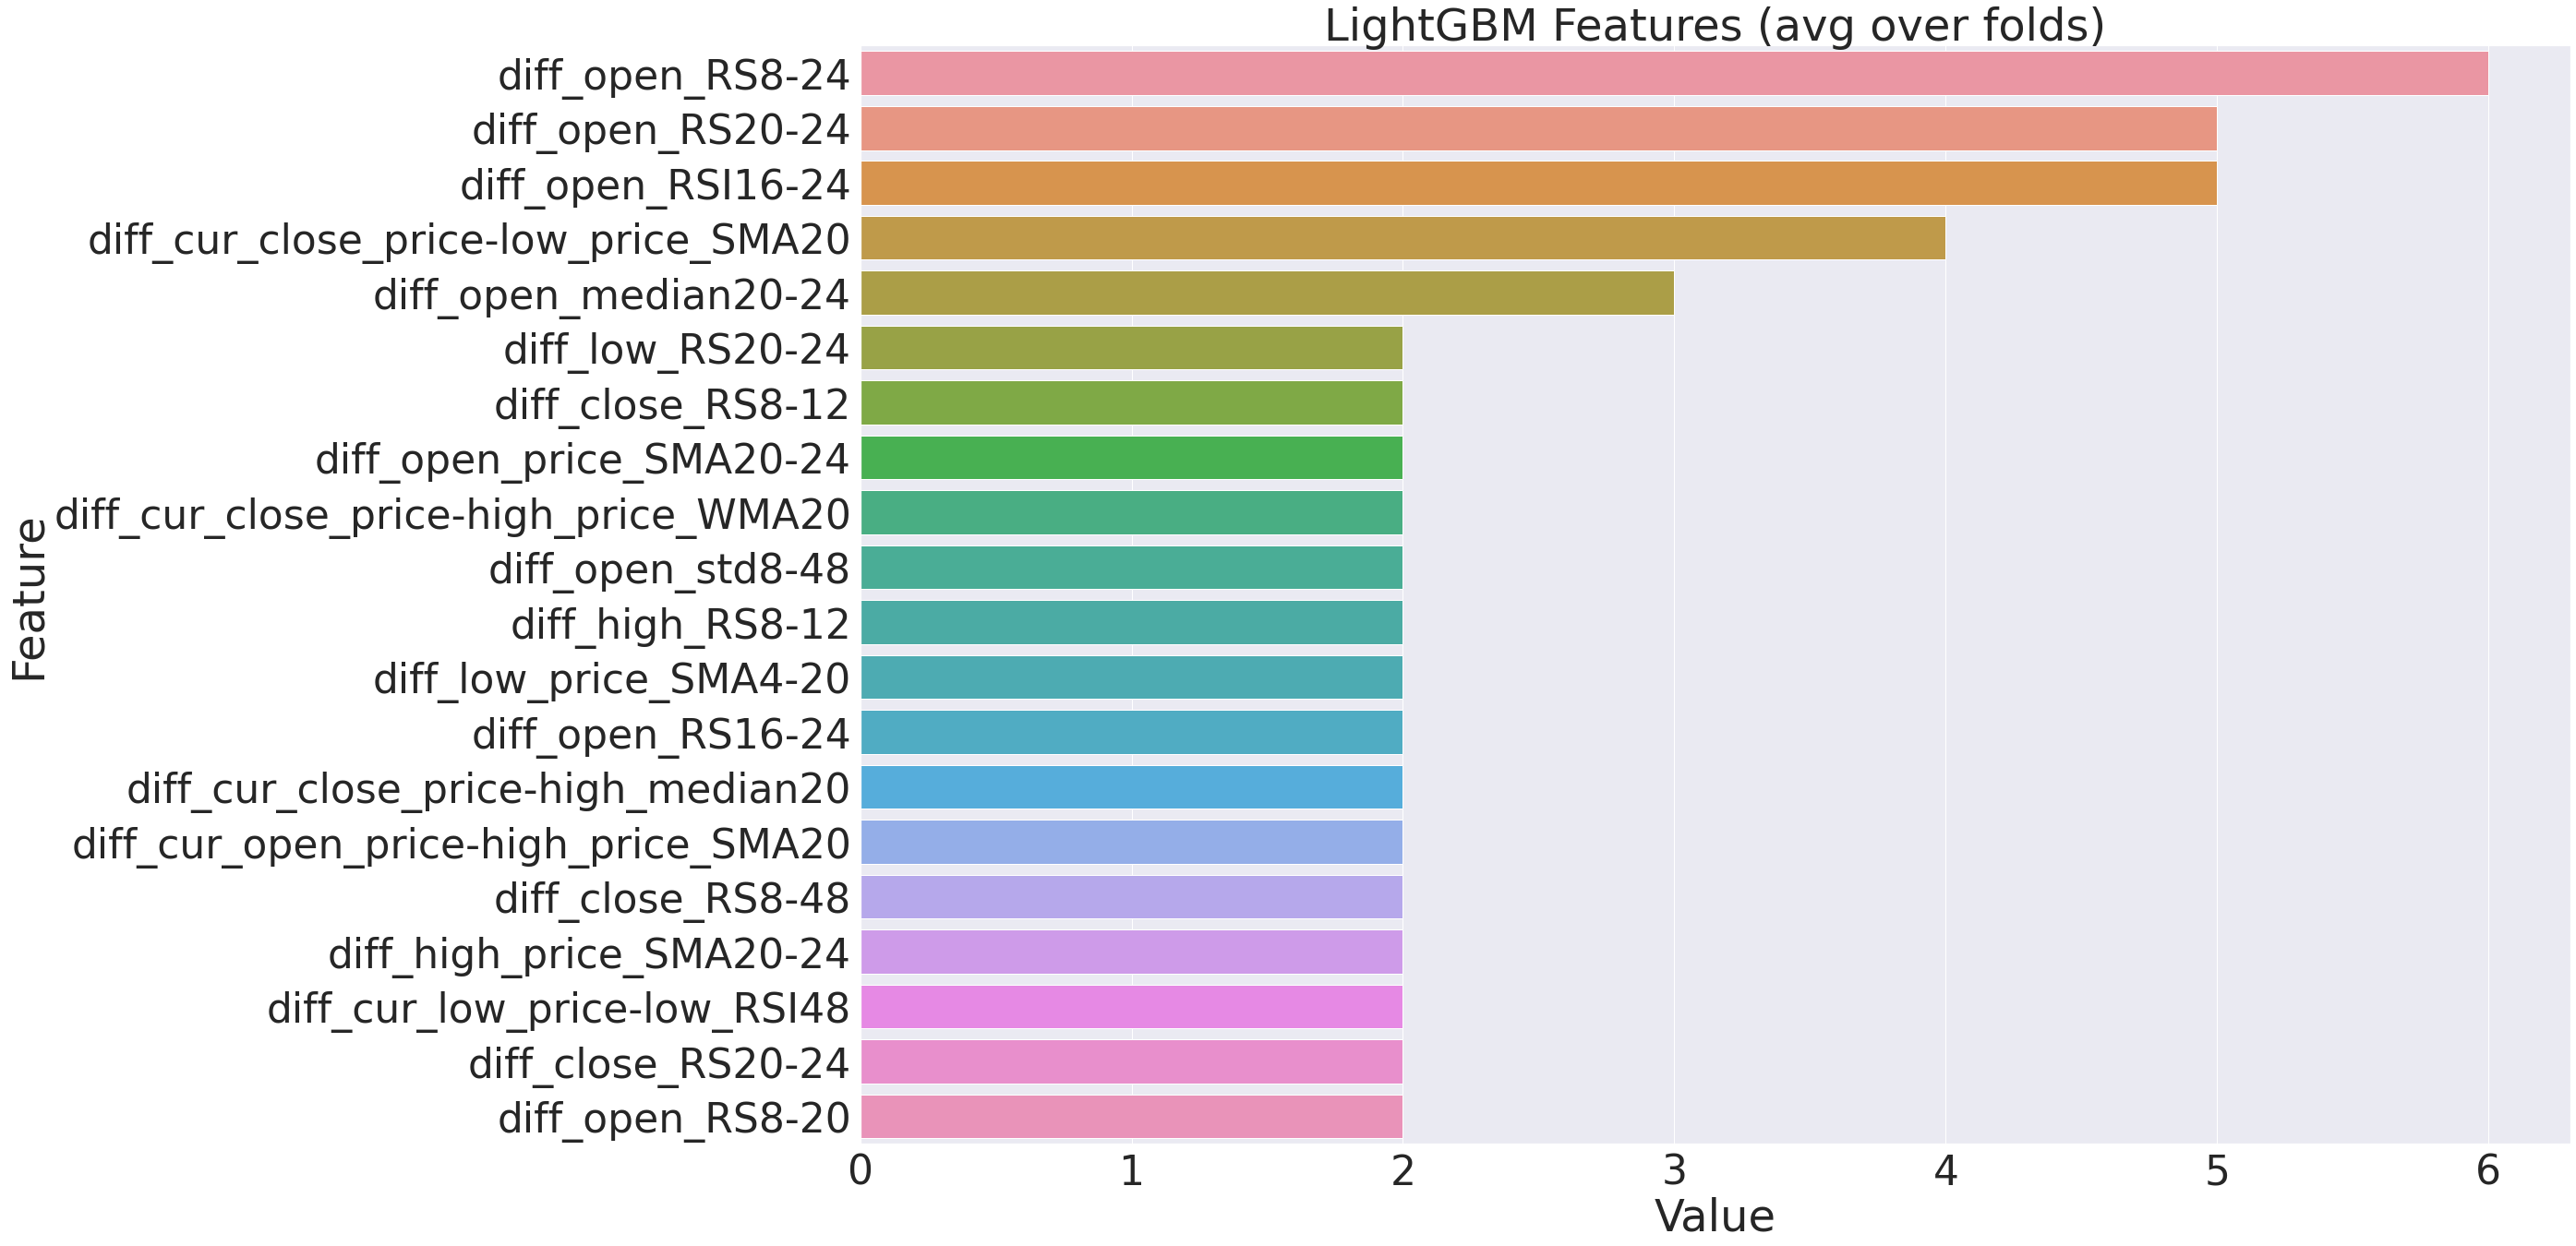

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
plotImp(model, X_test)

## 3. LightGBM regression

In [13]:
predicted_y = model.predict(X_train)
predicted_y = data_denormalization(predicted_y, X_train)

sns.set(font_scale = 2)

plt.figure(figsize=(16,9), dpi=90)
plt.plot(predicted_y[0:100], label="pred")
plt.plot(y_train.reset_index(drop=True)[0:100], label="real")
plt.title("Train set")
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [14]:
predicted_y = model.predict(X_val)
predicted_y = data_denormalization(predicted_y, X_val)

plt.figure(figsize=(16,9), dpi=90)
plt.plot(predicted_y[0:100], label="pred")
plt.plot(y_val[0:100], label="real")
plt.title("Validation set")
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [ ]:
predicted_y = model.predict(X_test)
predicted_y = data_denormalization(predicted_y, X_test)

plt.figure(figsize=(16,9), dpi=90)
plt.plot(predicted_y[0:100], label="pred")
plt.plot(y_test[0:100], label="real")
plt.title("Test set")
plt.legend()
plt.show()

In [ ]:
print("Accuracy:")
((predicted_y.to_numpy()[:-1] - y_test.to_numpy()[1:])*(y_test.to_numpy()[:-1]-y_test.to_numpy()[1:])>0).sum()/predicted_y.shape[0]

In [ ]:
predicted_y

In [ ]:
# print(classification_report(y_test, Binarizer(threshold=0.5).fit_transform(predicted_y.reshape(-1, 1))))
# print(confusion_matrix(y_test, Binarizer(threshold=0.5).fit_transform(predicted_y.reshape(-1, 1))))

In [ ]:
# print("Accuracy:")
# accuracy_score(y_test, Binarizer(threshold=0.5).fit_transform(predicted_y.reshape(-1, 1)))

In [ ]:
adb = AdaBoostClassifier(n_estimators=100)
adb.fit(X_train, y_train)

In [ ]:
print(classification_report(y_val, adb.predict(X_val)))

In [ ]:
print(metrics.classification_report(y_test, adb.predict(X_test)))

In [ ]:
(adb.predict(X_test) == y_test).sum()/y_test.shape[0]